Exploration of the Titanic Kaggle project. We'll use some simple machine learning tools to try to predict who survives as accurately as possible

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [3]:
titanic_train = pd.read_csv('train.csv')

In [162]:
titanic_test = pd.read_csv('test.csv')

In [5]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are quite a few options here with regard to what features to train on. The obvious ones are age, geneder and cabin fare. However we might be able to learn something
from the ticket type and number of parents/siblings a person had on board

Lets first see what missing data we have

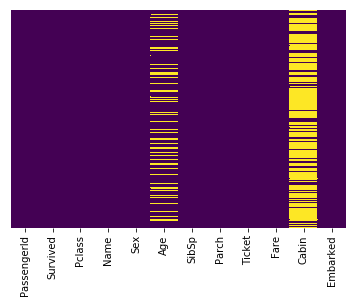

In [7]:
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [8]:
titanic_train.drop('Cabin',axis=1,inplace=True)

We're missing alot of age values, but we might be able to train an algorithm to predict the age of the passenger based on some of the other variables ...

In [27]:
titanic_train['Age'].isnull().sum()/len(titanic_train['Age'])

0.19865319865319866

In [54]:
titanic_train_null = titanic_train[titanic_train['Age'].isnull()]
titanic_train_nonnull = titanic_train[~titanic_train['Age'].isnull()]

### Predicting a person's age  

Lets see if we can use a Random Forest to do this, based on the other information that we have

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [56]:
titanic_train_nonnull.drop(['Name','Ticket','PassengerId'],axis=1,inplace=True)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
titanic_train_nonnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 8 columns):
Survived    714 non-null int64
Pclass      714 non-null int64
Sex         714 non-null object
Age         714 non-null float64
SibSp       714 non-null int64
Parch       714 non-null int64
Fare        714 non-null float64
Embarked    712 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 50.2+ KB


In [58]:
sex = pd.get_dummies(titanic_train_nonnull['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train_nonnull['Embarked'],drop_first=True)

In [59]:
titanic_train_nonnull.drop(['Sex','Embarked'],axis=1,inplace=True)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
age_df = pd.concat([titanic_train_nonnull,sex,embark],axis=1)

In [63]:
X = age_df.drop(['Age'],axis=1)
y = age_df['Age']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [70]:
rfreg = RandomForestRegressor(n_estimators=800,min_samples_leaf=2,oob_score=True)

In [71]:
rfreg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [72]:
rfreg.oob_score_

0.27350109137908085

In [73]:
rfreg.feature_importances_

array([0.06682353, 0.15608545, 0.14038439, 0.19226233, 0.33985574,
       0.0556907 , 0.005135  , 0.04376284])

In [74]:
X_train.head()

,Survived,Pclass,SibSp,Parch,Fare,male,Q,S
211,1,2,0,0,21.0000,0,0,1
179,0,3,0,0,0.0000,1,0,1
663,0,3,0,0,7.4958,1,0,1
69,0,3,2,0,8.6625,1,0,1
569,1,3,0,0,7.8542,1,0,1


In [75]:
age_predictions = rfreg.predict(X_test)

In [76]:
rfreg.score(X_test,y_test)

0.3261370975142702

Text(0,0.5,'Actual result')

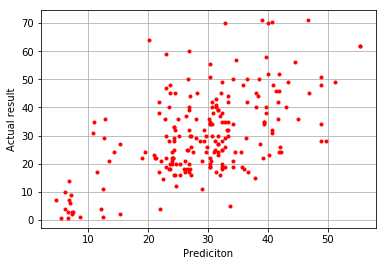

In [80]:
plt.figure()
plt.plot(age_predictions,y_test,'r.')
plt.grid()
plt.xlabel('Prediciton')
plt.ylabel('Actual result')

Perhaps surprisingly the model is not very good at predicting a person's age off of these various other features. Nevertheless its the best we have for now so lets go ahead
and use it to fill the NaNs in the age column

In [82]:
titanic_train_null.drop(['Name','Ticket','PassengerId'],axis=1,inplace=True)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
sex = pd.get_dummies(titanic_train_null['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train_null['Embarked'],drop_first=True)
titanic_train_null.drop(['Sex','Embarked'],axis=1,inplace=True)
age_df_null = pd.concat([titanic_train_null,sex,embark],axis=1)
X_null = age_df_null.drop(['Age'],axis=1)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
y_null = rfreg.predict(X_null)

In [86]:
age_df_null['Age'] = y_null

In [87]:
titanic_age_interp = pd.concat([age_df,age_df_null])

In [88]:
titanic_age_interp.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


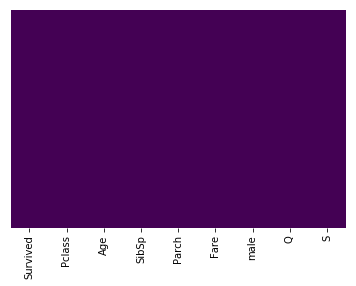

In [89]:
sns.heatmap(titanic_age_interp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Data visualization

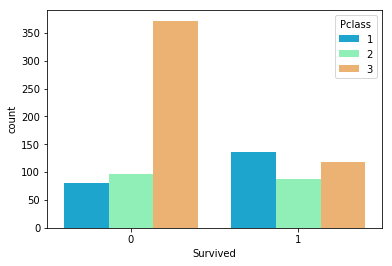

In [94]:
#See if there is any separation of surivival by cabin class - there 

sns.countplot(x='Survived',hue='Pclass',data=titanic_age_interp,palette='rainbow')

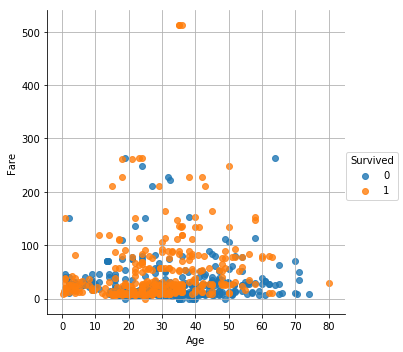

In [97]:
#See if there is any separation of survuval rate by age and fare 

sns.lmplot(x='Age',y='Fare',data=titanic_age_interp,fit_reg=False,hue='Survived')
plt.grid()

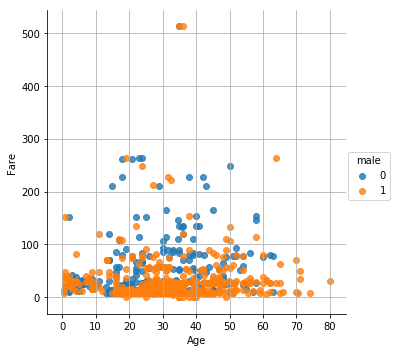

In [98]:
sns.lmplot(x='Age',y='Fare',data=titanic_age_interp,fit_reg=False,hue='male')
plt.grid()

As an aside it looks like males generally paid a lower fare, but they were also less likely to survive. This is probably because the majoroty of people in P3 class
where probably male

In [102]:
titanic_age_interp.groupby('male').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Q,S
male,,,,,,,,
0,0.742038,2.159236,27.060549,0.694268,0.649682,44.479818,0.114650,0.646497
1,0.188908,2.389948,30.972984,0.429809,0.235702,25.523893,0.071057,0.764298


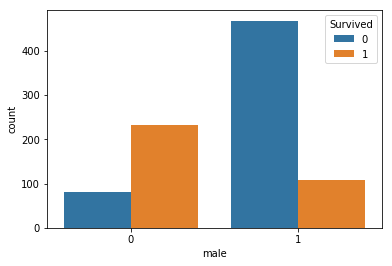

In [103]:
sns.countplot(x='male',hue='Survived',data=titanic_age_interp)

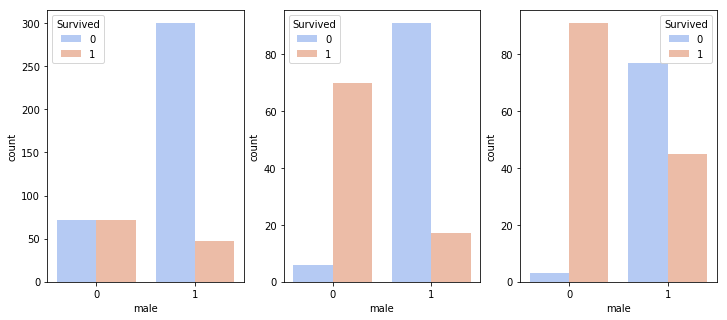

In [123]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
sns.countplot(x='male',hue='Survived',data=titanic_age_interp[titanic_age_interp['Pclass']==3],ax=ax1,palette='coolwarm')
sns.countplot(x='male',hue='Survived',data=titanic_age_interp[titanic_age_interp['Pclass']==2],ax=ax2,palette='coolwarm')
sns.countplot(x='male',hue='Survived',data=titanic_age_interp[titanic_age_interp['Pclass']==1],ax=ax3,palette='coolwarm')

It seems that in general, females were more likely to survive than males, and the propertion of females who survived dramatically increases with improving cabin class

### Application of random forest classifier

In [124]:
from sklearn.ensemble import RandomForestClassifier

In [126]:
X = titanic_age_interp.drop(['Survived'],axis=1)
y = titanic_age_interp['Survived']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [141]:
rfclass = RandomForestClassifier(n_estimators=1000,min_samples_leaf=2,oob_score=True)

In [142]:
rfclass.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [140]:
rfclass.oob_score_

0.8298555377207063

In [172]:
rfclass.feature_importances_

array([0.0982465 , 0.23908508, 0.04957189, 0.03608662, 0.22309516,
       0.31566992, 0.01149425, 0.02675059])

#### Age, gender, fare and class are the most important features. Cabin location within the ship is probably important too, but we don't have this much of this information

In [173]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
301,3,27.243451,2,0,23.2500,1,1,0
474,3,22.000000,0,0,9.8375,0,0,1
264,3,29.029601,0,0,7.7500,0,1,0
671,1,31.000000,1,0,52.0000,1,0,1
716,1,38.000000,0,0,227.5250,0,0,0


In [143]:
predictions = rfclass.predict(X_test)

In [144]:
from sklearn.metrics import classification_report

In [145]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.82      0.94      0.87       157
          1       0.89      0.70      0.78       111

avg / total       0.85      0.84      0.84       268



Not bad - we're able to predict with 85% accuracy here

What about the hold out dataset? Lets take a look at that now

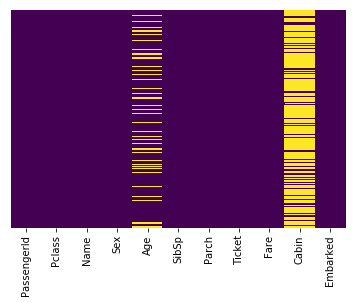

In [163]:
sns.heatmap(titanic_test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [164]:
titanic_test.drop(['Cabin'],axis=1,inplace=True)

In [171]:
#We're just going to remove the nan information about age
titanic_test.dropna(inplace=True)

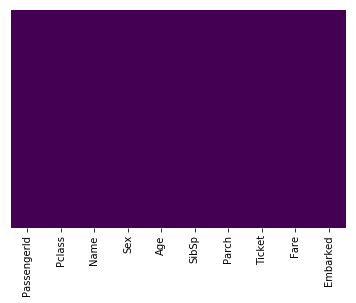

In [166]:
sns.heatmap(titanic_test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [167]:
titanic_test.drop(['Name','Ticket','PassengerId'],axis=1,inplace=True)
sex = pd.get_dummies(titanic_test['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_test['Embarked'],drop_first=True)
titanic_test.drop(['Sex','Embarked'],axis=1,inplace=True)
titanic_test_ready = pd.concat([titanic_test,sex,embark],axis=1)

In [168]:
titanic_test_ready.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.8292,1,1,0
1,3,47.0,1,0,7.0000,0,0,1
2,2,62.0,0,0,9.6875,1,1,0
3,3,27.0,0,0,8.6625,1,0,1
4,3,22.0,1,1,12.2875,0,0,1


In [169]:
final_predictions = rfclass.predict(titanic_test_ready)

In [170]:
final_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,

We're getting an accuracy of about 85%. The best kaggle scores are about 90%. To improve this further we should think of some features to engineer